In [7]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import strip_punctuation
print((gensim.__version__)) 
import shap
import ast
import pandas as pd
import ast
import numpy as np
import gensim
import pickle
import shap
from transformers import AutoTokenizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline

4.1.2


In [2]:
y_test = pd.read_csv("C:/Users/berl03/Desktop/LIME/1 příprava dat/y_test.csv")
y_train = pd.read_csv("C:/Users/berl03/Desktop/LIME/1 příprava dat/y_train.csv")
X_train = pd.read_csv("C:/Users/berl03/Desktop/LIME/1 příprava dat/X_train.csv")
X_test = pd.read_csv("C:/Users/berl03/Desktop/LIME/1 příprava dat/X_test.csv")
X_train_feats = X_train.drop(columns=["Unnamed: 0"])
X_test_feats  = X_test .drop(columns=["Unnamed: 0"])
y_test['abstract_tokenized'] = y_test['abstract_tokenized'].apply(ast.literal_eval)
loaded_model = lreg_w2v_avg = pickle.load(open("C:/Users/berl03/Desktop/LIME/1 příprava dat/lreg_w2v_avg_2020.sav", 'rb'))
w2v_model =gensim.models.Word2Vec.load("C:/Users/berl03/Desktop/LIME/1 příprava dat/w2v_published_only_english_between_2019 and 2020.model")

In [4]:
texts = y_test["abstract_cleaned"].tolist()

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline

In [30]:
# --- 3) Transformer: text → průměr embeddingů ----------------------------
class W2vAverager(BaseEstimator, TransformerMixin):
    def __init__(self, w2v):
        self.w2v = w2v
        self.dim = w2v.vector_size
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        vecs = []
        for txt in X:
            words = [w for w in txt.split() if w in self.w2v.wv]
            if words:
                vecs.append(np.mean(self.w2v.wv[words], axis=0))
            else:
                vecs.append(np.zeros(self.dim))
        return np.vstack(vecs)

pipeline = make_pipeline(
    W2vAverager(w2v_model),
    loaded_model            # LR.predict_proba
)

# --- 4) Kompatibilní whitespace‐tokenizer pro SHAP -----------------------
class WhitespaceTokenizer:
    def __call__(self, text, return_offsets_mapping=False):
        tokens = text.split()
        if return_offsets_mapping:
            offsets = []
            cursor = 0
            for t in tokens:
                # najdeme pozici tokenu v původním řetězci
                start = text.find(t, cursor)
                end   = start + len(t)
                offsets.append((start, end))
                cursor = end
            return {"input_ids": tokens, "offset_mapping": offsets}
        return {"input_ids": tokens}

    # SHAP bude volat tuto metodu, aby zpátky dostal tokeny
    def convert_ids_to_tokens(self, token_ids):
        return token_ids

    # SHAP může zkusit volat decode() na jednotlivá "id"
    def decode(self, id_list):
        return id_list[0]

masker = shap.maskers.Text(WhitespaceTokenizer())

explainer = shap.Explainer(
    pipeline.predict_proba,
    masker,
    output_names=["Low", "High"]
)

# --- 5) Spočti SHAP values (celá sada nebo vzorek) -----------------------
# Pro finální výsledky použij klidně celý test: sample_texts = texts
sample_texts = texts
shap_values = explainer(sample_texts)

# --- 6) Sestroj globální SHAP‐importances ------------------------------
# spoj tokeny i shap hodnoty pro třídu "High" (index 1)
all_tokens = np.concatenate([ toks for toks in shap_values.data ])
all_shaps  = np.concatenate([ sv[:, 1] for sv in shap_values.values ])

df_shap = (
    pd.DataFrame({
        "word": all_tokens,
        "shap":   np.abs(all_shaps)
    })
    .groupby("word")["shap"]
    .mean()
    .reset_index()
    .sort_values("shap", ascending=False)
)

print("Top-20 globálních SHAP importances (whitespace tokens):")
print(df_shap.head(20))


Partition explainer: 8646it [15:03,  9.47it/s]                                                                         


Top-20 globálních SHAP importances (whitespace tokens):
                   word      shap
18438  intussusceptive   0.273533
25620          podcast   0.169538
14399            forget  0.131029
1734               2019  0.119258
7077                bus  0.112248
30293         sickened   0.108893
31822           suicide  0.101021
20875           michel   0.100373
33392  transmissibility  0.100144
2019              2495   0.093208
2342             30–70   0.092803
17019               igg  0.090167
3835            achieve  0.085814
34648              var   0.080926
9517       coronovirus   0.080366
7784            century  0.076012
29639            secret  0.074944
10241        cysteinyl   0.074771
35986        ‘covid-19’  0.074761
24957         performed  0.074274


In [31]:
len(df_shap)

36494

array([[<AxesSubplot:title={'center':'shap'}>]], dtype=object)

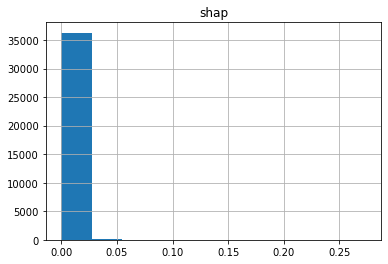

In [33]:
df_shap.hist()

In [32]:
df_shap.to_csv("C:/Users/berl03/Desktop/LIME/4 SHAP  výpočet/shap_imp.csv")